# Unidad 3 - 03 Laboratorio de Reducción de la dimensión

Haremos nuestras versiones y las compararemos con las que ya vienen en scikitlearn.

In [28]:
# Cargamos las librerías, quizás algunas de más
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn.neighbors as nb
import sklearn.utils.graph as ug
from numpy import *
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import LabelEncoder

from sklearn import manifold, datasets
from sklearn.decomposition import PCA
from scipy.spatial import distance as spd
%matplotlib inline

import scipy
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path

El ejemplo que seguiremos es el Swiss Roll.

In [29]:
sr_points, sr_color = datasets.make_swiss_roll(n_samples=1500, random_state=0)

In [ ]:
sr_points.shape

(1500, 3)

Definamos un tipo de gráfico que utilizaremos a lo largo del lab.

In [30]:
def grafica3d(datos, string_de_texto):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    fig.add_axes(ax)
    ax.scatter(datos[:, 0], datos[:, 1], datos[:, 2], c=sr_color, s=50, alpha=0.8)
    ax.set_title(string_de_texto)
    ax.view_init(azim=-66, elev=12)
    _ = ax.text2D(0.8, 0.05, s="n_samples=1500", transform=ax.transAxes)
    return _
def grafica3d_sup2d(datos, string_de_texto):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    fig.add_axes(ax)
    ax.scatter(datos[:, 0], datos[:, 1], c=sr_color, s=50, alpha=0.8)
    ax.set_title(string_de_texto)
    ax.view_init(azim=-66, elev=12)
    _ = ax.text2D(0.8, 0.05, s="n_samples=1500", transform=ax.transAxes)
    return _

Text(0.8, 0.05, 'n_samples=1500')

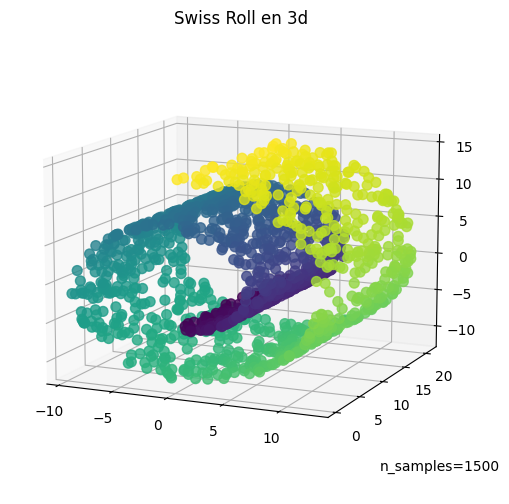

In [31]:
grafica3d(sr_points, "Swiss Roll en 3d")

## 1 - MULTIDIMENSIONAL SCALING (MDS)


El objetivo de este algoritmo es preservar las distancias/similaridades/dis-similaridades entre todos los pares de elementos.

Seguimos los siguientes pasos. Suponiendo dato la matriz $D$ de las distancias entre pares de datos, de tamaño $n\times n$.

* Consideramos la matriz $A$, que es el producto de Hadamard de $D$ consigo misma.
* Definimos la matriz $H = I_{n} - (11^T)/n$, donde $I_{n}$ es la matriz identidad $n\times n$, y $11^T$ es la matriz $n\times n$ de 1's en cada entrada.
* Definimos la matriz $B = -1/2HDH$.
* Hacemos la descoposición en valores singulares $UWV^T$ = svd($B$).
* Creamos la matriz $A′ = U_{k}W^{1/2}_k$ (donde $k$ son los autovalores más grandes y sus autovectores correspondientes en de $U$).


In [32]:
#D : matriz distancia
#k: cantidad de vectores a usar
def mds(D,k):
    n = D.shape[0]
    A = pow(D,2)
    H = eye(n) - (1.0/n) * ones(n)
    B = -(1.0/2) * dot(H,dot(A,H))
    U,L,V = linalg.svd(B)
    return dot(U[:,:k],sqrt(diag(L)[:k,:k]))

In [ ]:
eye?

In [ ]:
pow?

In [33]:
# Armamos la matriz de distancias
# primero la función distancia entre puntos
def distancia_entre_puntos(x, y):
    dist = np.linalg.norm(x-y)
    return dist
# luego la matriz
D = np.zeros((1500,1500))
for i in range(1500):
    for j in range(1500):
        d = distancia_entre_puntos(sr_points[i],sr_points[j])
        D[i][j] = d

In [ ]:
D

array([[ 0.        , 17.18726195,  6.96934848, ..., 14.20952497,
        13.30479844, 17.52545047],
       [17.18726195,  0.        , 17.01786005, ..., 13.10158815,
         6.37579656, 14.32991933],
       [ 6.96934848, 17.01786005,  0.        , ..., 12.51385163,
        15.20814676, 19.65993393],
       ...,
       [14.20952497, 13.10158815, 12.51385163, ...,  0.        ,
        10.89167341, 10.25864665],
       [13.30479844,  6.37579656, 15.20814676, ..., 10.89167341,
         0.        ,  9.56148616],
       [17.52545047, 14.32991933, 19.65993393, ..., 10.25864665,
         9.56148616,  0.        ]])

Ahora aplicamos nuestro algoritmo MDS.

In [34]:
mds_points_nuestros = mds(D,2) # fuimos a 2d

Text(0.8, 0.05, 'n_samples=1500')

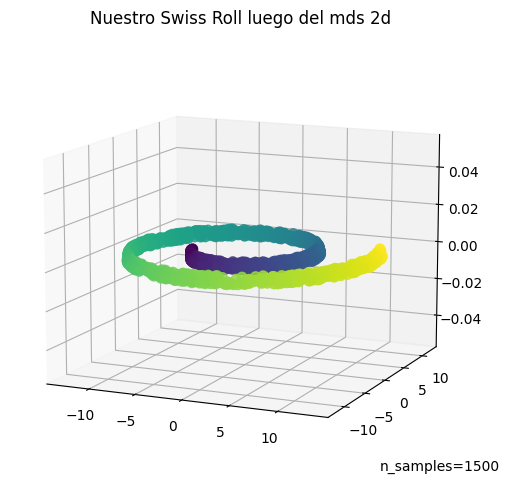

In [35]:
grafica3d_sup2d(mds_points_nuestros, "Nuestro Swiss Roll luego del mds 2d")

Ahora veamos cómo lo hace scikitlearn

In [ ]:
manifold.MDS?

In [36]:
n_components = 2
mds_skl = manifold.MDS(n_components, max_iter=100, n_init=1)
mds_points = mds_skl.fit_transform(sr_points)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Text(0.8, 0.05, 'n_samples=1500')

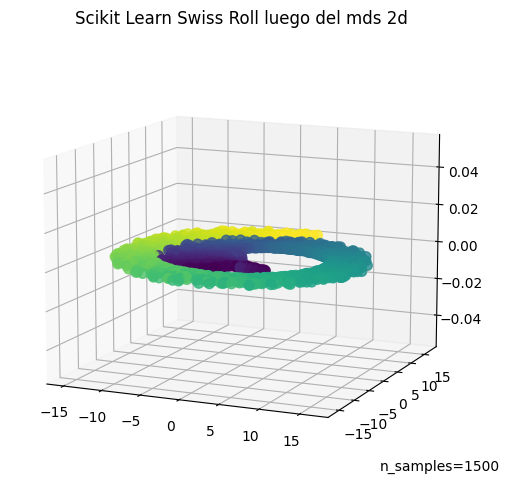

In [37]:
grafica3d_sup2d(mds_points, "Scikit Learn Swiss Roll luego del mds 2d")

## ISOMETRIC MAPPING (ISOMAP)


El algoritmo se basa en encontrar los entornos de cada punto. Por eso tenemos que pasar por el algoritmo de k-nearest neighbours (que no hemos visto en el curso, algo se puede leer de la wiki https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm), y armar los grafos.

Los pasos son:

    * Encontrar los k-nn de cada punto.
    * Construir un grafo donde cada nodo sólo esté conectado con los k-nn.
    * Armar la matriz del grafo (y considerarla pesada con la distancia euclídea, pues en cada entorno podemos pensar que estamos en el espacio euclídeo).
    * Hallar las distancias entre todos los nodos del grafo, según algún algoritmo tipo shortest path, y armar la matriz distancia.
    * Aplicar MDS a la matriz distancia.



In [38]:
def isomap(D,k,n_neighbors):
    # algoritmo k-nearest neighbour
    knr = nb.NearestNeighbors(n_neighbors= n_neighbors)
    knr.fit(D)
    # grafo de entornos donde las aristas están pesadas por la distancia euclídea
    kng = nb.kneighbors_graph(knr,n_neighbors,mode='distance')
    # distancia entre nodos según algoritmo shortest path
    ##Dist_g = ug.graph_shortest_path(kng,directed=False,method='auto')
    Dist_g = scipy.sparse.csgraph.shortest_path(kng, method='auto', directed=True, return_predecessors=False, unweighted=False, overwrite=False, indices=None)
    # aplicamos MDS ()
    return mds(Dist_g,k)

In [39]:
n_neighbors = 10
isomap_points_nuestros = isomap(D,2,n_neighbors)

Text(0.8, 0.05, 'n_samples=1500')

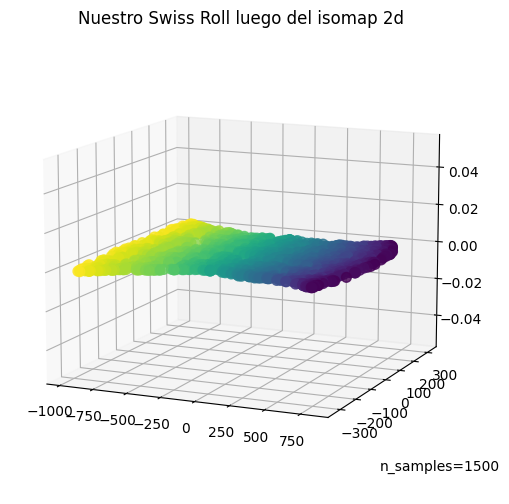

In [40]:
grafica3d_sup2d(isomap_points_nuestros, "Nuestro Swiss Roll luego del isomap 2d")

In [ ]:
manifold.Isomap?

In [ ]:
fit_transform?

Object `fit_transform` not found.


In [41]:
n_neighbors = 10
isomap_points = manifold.Isomap().fit_transform(sr_points)

Text(0.8, 0.05, 'n_samples=1500')

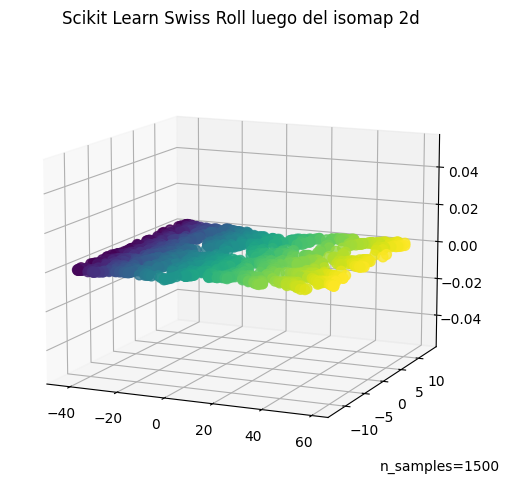

In [42]:
grafica3d_sup2d(isomap_points, "Scikit Learn Swiss Roll luego del isomap 2d")

## EJERCICIOS:

Vale googlear, kagglear, wikipediar, etc.!

1) Aplicar MDS e ISOMAP (pueden ser desde skl!) a MNIST. Interpretar!

2) Aplicar MDS e ISOMAP (pueden ser desde skl!) a Iris. Interpretar!